In [142]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


# Data

The data sets are already standardized with the `data/clean01.py` and `data/clean02.py` scripts so
whichever operation we can do on one data set, we can do on the other.

Genshin Impact, being the wonderful game that it is, has decided that it is going to have three types
of banners players can pull from. Thus, I am going to analyze them separately because _I do be eager
like that_.

## Data Format

I am going to skip the format of the original data set because it is irrelevant to this notebook.

The rows of the data sets are as following:

- **Rarity**: how many stars the character/weapon is classified as
- **Date**: date of the pull
- **Time**: time of the pull
- **Banner**: type of banner, described as following:
  - _200_: Permanent banner, always available to players
  - _301_ and _400_: Limited character banner, changes every now and then
  - _302_: Limited weapon banner, changes every now and then
- **Type**: drop type, either character or weapon
  - This attribute might interfere with our model so it might be dropped later on


In [143]:
from datetime import date, timedelta


def simplify_dt(given_dt: str):
    given_date, given_time = given_dt.split(' ')
    yr, mo, da = map(int, given_date.split('-'))
    hr, mi, _ = map(int, given_time.split(':'))

    pull_time = hr + round(mi / 60)
    pull_date = date(yr, mo, da) + timedelta(pull_time // 24)

    return (pull_date, pull_time % 24)


data_set01 = pd.read_csv("data/data01.csv")
data_set02 = pd.read_csv("data/data02.csv")
full_df = pd.concat([data_set01, data_set02]).reset_index().drop(
    ["Type", "index"], axis=1)
full_df["DateTime"] = full_df["DateTime"].apply(simplify_dt)

full_df.sample(5)


,Rarity,DateTime,Banner
235001,3,"(2021-08-10, 18)",301
355775,3,"(2022-03-09, 13)",200
243842,3,"(2022-04-19, 19)",301
179292,3,"(2020-11-11, 12)",301
356990,3,"(2022-07-13, 12)",301


# Reusable Code for Analysis

These are just some constants and functions used for analyzing the data.

## Constants

In [144]:
RELEASE_DATE = date(2020, 9, 28)
days_since_release = (date.today() - RELEASE_DATE).days

## Functions used to transform the data

In [145]:
def transform_rarity(banner: pd.DataFrame, cond_series: pd.Series, dimension: tuple[int, int]):
    grouped_counts = banner[cond_series]\
        .groupby("DateTime")\
        .count()

    ret_matrix = np.zeros(dimension)
    for i, key in enumerate(grouped_counts.index):
        d, t = key
        ret_matrix[t, d] = grouped_counts.iloc[i]

    return ret_matrix


def transform_func(banner: pd.DataFrame, date_transformer: callable, dimension: tuple[int, int]) -> list[np.ndarray]:
    banner = banner.drop("Banner", axis=1)
    banner["DateTime"] = banner["DateTime"].map(date_transformer)

    total = transform_rarity(banner, banner.Rarity != 0, dimension)
    five_stars = transform_rarity(banner, banner.Rarity == 5, dimension)
    four_stars = transform_rarity(banner, banner.Rarity == 4, dimension)

    return [total, five_stars / (total + 1), four_stars / (total + 1)]


def first_doy(d): return date(d.year, 1, 1)

def dow_transformer(dt): return (dt[0].weekday(), dt[1])
def dom_transformer(dt): return (dt[0].day - 1, dt[1])
def doy_transformer(dt): return ((first_doy(dt[0]) - dt[0]).days, dt[1])
def dsr_transformer(dt): return ((dt[0] - RELEASE_DATE).days, dt[1])

## Visualization Helpers, yoinked from Matplotlib's website

In [146]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, cmap="gray", **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    # ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    # ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


In [147]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

## Functions used to visualize the data

In [148]:
def dow_heatmap(data: np.ndarray, ax: plt.Axes, bar_label: str, title: str):
    row_label = np.arange(0, 24)
    col_label = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    heatmap(data, row_label, col_label, ax, cbarlabel=bar_label)
    ax.set_title(title)

def dom_heatmap(data: np.ndarray, ax: plt.Axes, bar_label: str, title: str):
    row_label = np.arange(0, 24)
    col_label = np.arange(1, 32)
    heatmap(data, row_label, col_label, ax, cbarlabel=bar_label)
    ax.set_title(title)

def doy_heatmap(data: np.ndarray, ax: plt.Axes, bar_label: str):
    n = len(ax)
    portion = data.shape[1] // n

    row_label = np.arange(0, 24)
    col_label = np.arange(1, data.shape[1] + 1)

    for i in range(n):
        split_col = col_label[i * portion: (i + 1) * portion]
        split_data = data[:, i * portion: (i + 1) * portion]
        heatmap(split_data, row_label, split_col, ax[i], cbarlabel=bar_label)

# Every Banner Combined


## Day of the Week


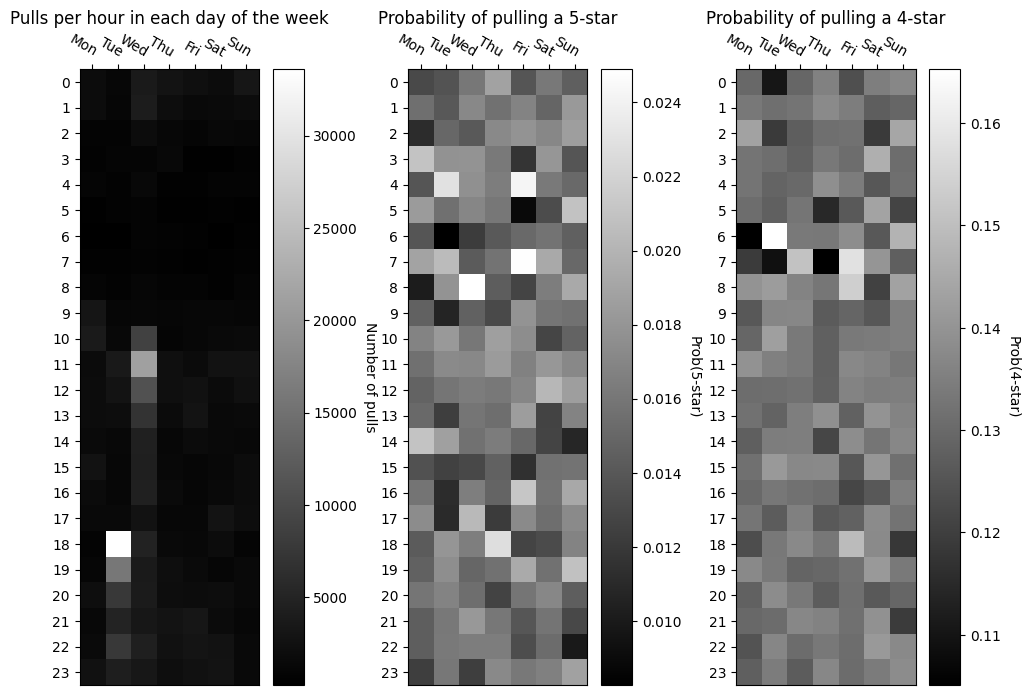

In [149]:
total_dow = transform_func(full_df, dow_transformer, (24, 7))
all_total, all_fives, all_fours = total_dow
_, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 8))

dow_heatmap(all_total, ax1, "Number of pulls", "Pulls per hour in each day of the week")
dow_heatmap(all_fives, ax2, "Prob(5-star)", "Probability of pulling a 5-star")
dow_heatmap(all_fours, ax3, "Prob(4-star)", "Probability of pulling a 4-star")


## Day of Month


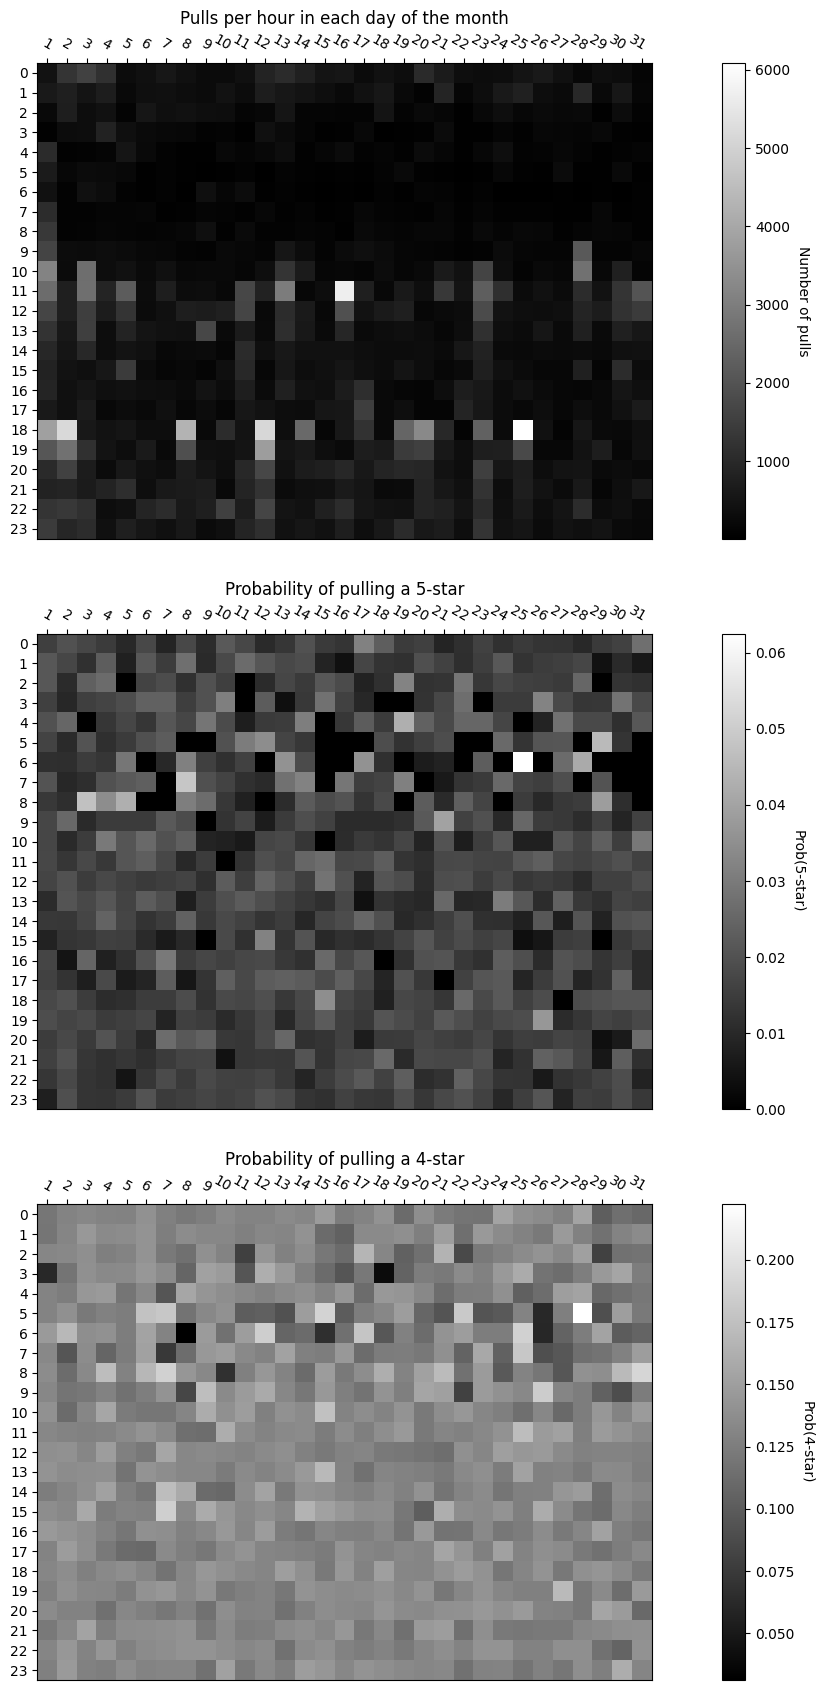

In [150]:
total_dom = transform_func(full_df, dom_transformer, (24, 31))
all_dom, all_fives, all_fours = total_dom
_, (ax1, ax2, ax3) = plt.subplots(3, figsize=(18, 21))

dom_heatmap(all_dom, ax1, "Number of pulls", "Pulls per hour in each day of the month")
dom_heatmap(all_fives, ax2, "Prob(5-star)", "Probability of pulling a 5-star")
dom_heatmap(all_fours, ax3, "Prob(4-star)", "Probability of pulling a 4-star")

## Day of Year


### Pulls

In [156]:
total_doy = transform_func(full_df, doy_transformer, (24, 365))
all_total, all_fives, all_fours = total_doy

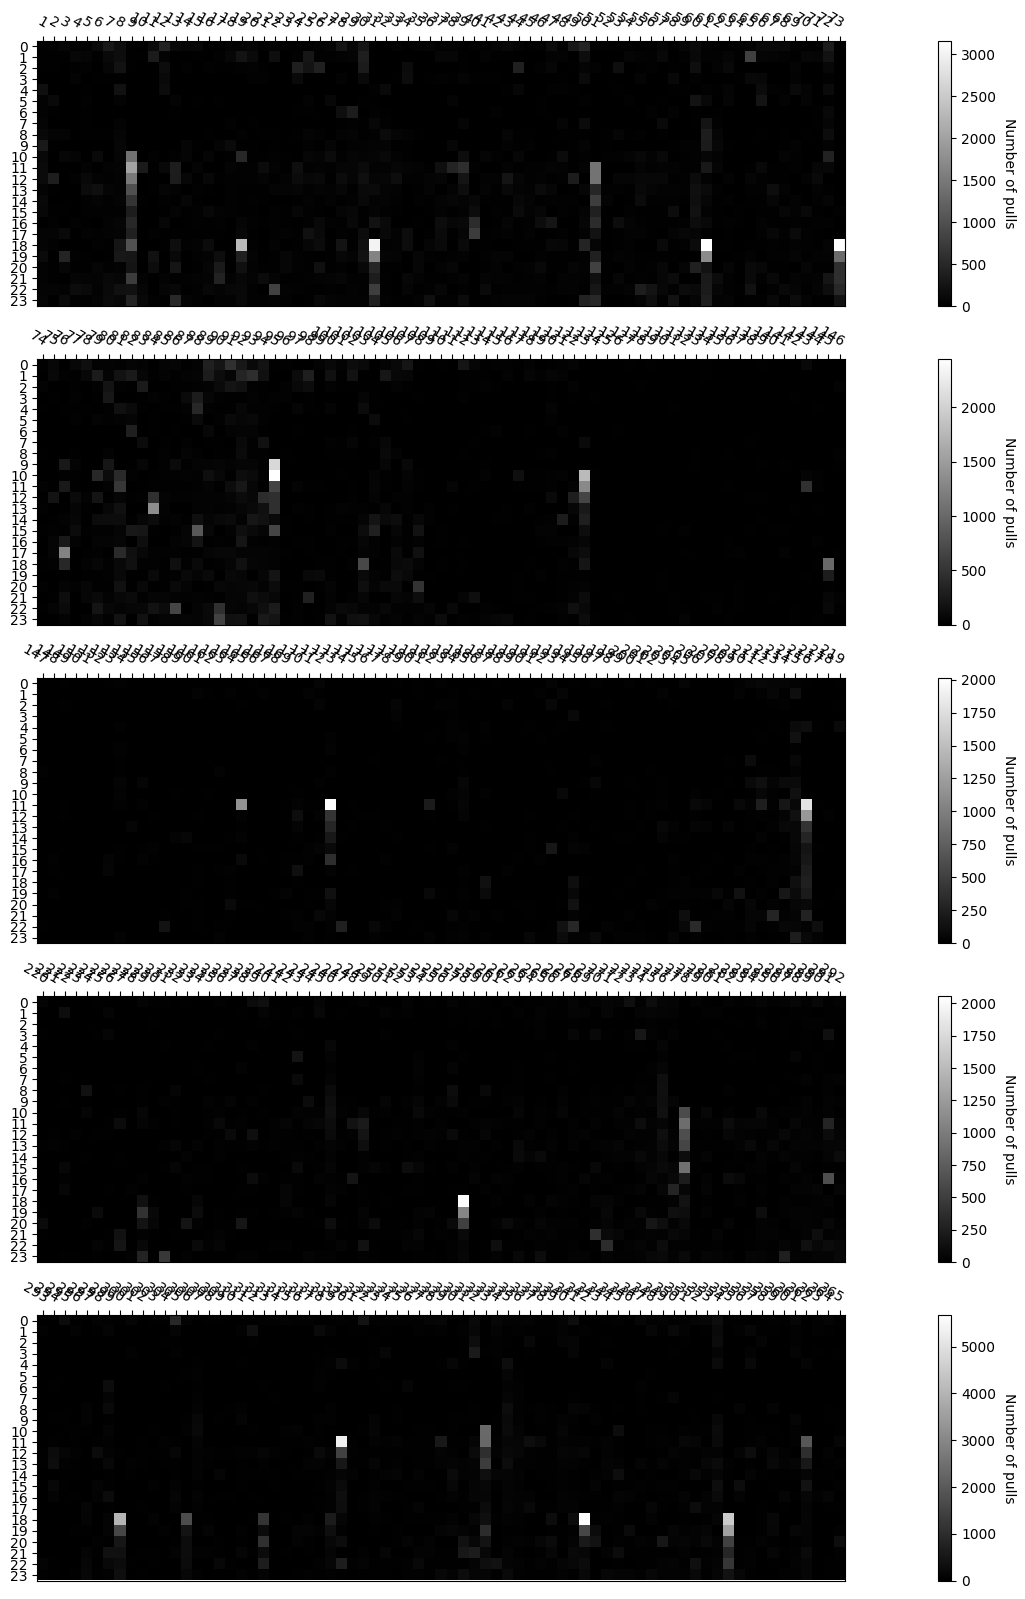

In [157]:
_, ax = plt.subplots(5, figsize=(24, 20))
doy_heatmap(all_total, ax, "Number of pulls")

### 5-star

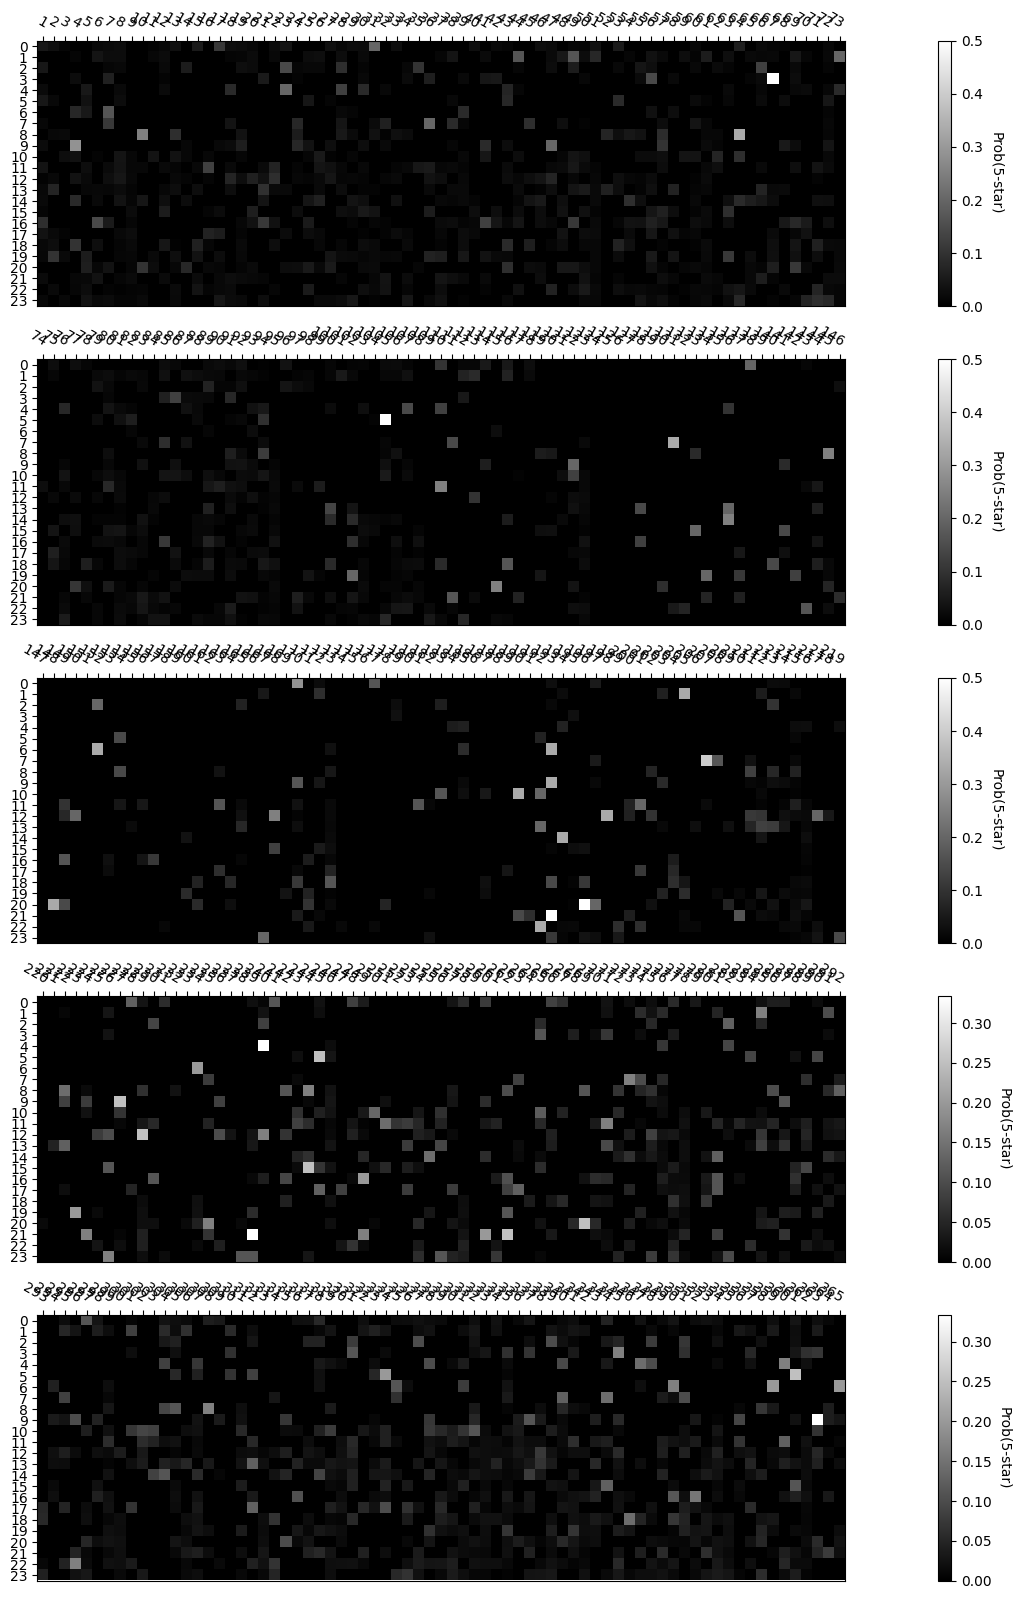

In [158]:
_, ax = plt.subplots(5, figsize=(24, 20))
doy_heatmap(all_fives, ax, "Prob(5-star)")

### 4-star

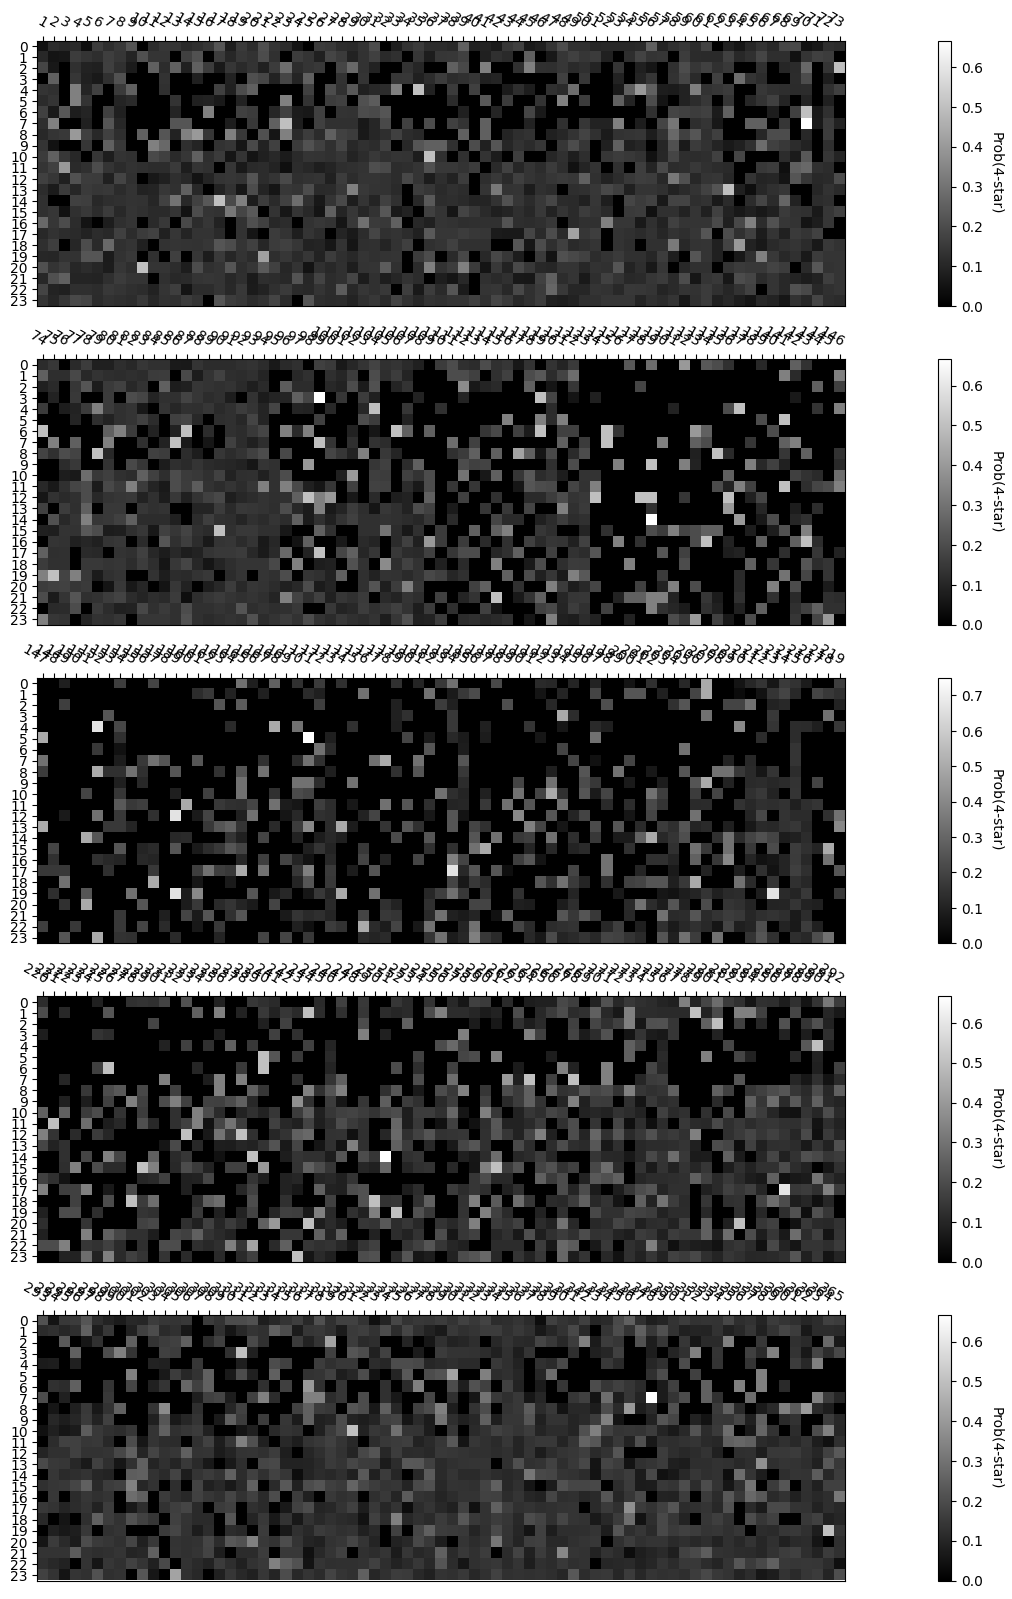

In [159]:
_, ax = plt.subplots(5, figsize=(24, 20))
doy_heatmap(all_fours, ax, "Prob(4-star)")

## Days since release


In [160]:
total_dsr = transform_func(full_df, dsr_transformer, (24, days_since_release))
total_dsr = map(lambda lst: lst[:, :200], total_dsr)